## Imports

In [202]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from tqdm import tqdm
#models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
#metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support,ConfusionMatrixDisplay


In [203]:
df=pd.read_csv('titanic.csv')
rand_state=25

### 1) Describe Data

In [204]:
df.columns

Index(['row ID', 'pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'cabinCategory', 'embarked', 'boat', 'body',
       'home.dest'],
      dtype='object')

In [205]:
df.head(2)

,row ID,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,cabinCategory,embarked,boat,body,home.dest
0,Row0,1,yes,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,B,S,2,NaN,"St Louis, MO"
1,Row1,1,yes,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,C,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [206]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pclass,1309.0,2.294882,0.837836,1.0000,2.0000,3.0000,3.000,3.0000
age,1046.0,29.881135,14.413500,0.1667,21.0000,28.0000,39.000,80.0000
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.0000,1.000,8.0000
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.0000,0.000,9.0000
fare,1308.0,33.295479,51.758668,0.0000,7.8958,14.4542,31.275,512.3292
body,121.0,160.809917,97.696922,1.0000,72.0000,155.0000,256.000,328.0000


### 2) Feature selection 
#### a) We can drop all the variables with no correlation to our dependent variable
 - **name**: the name of each passenger is unique
 - **Row**: same as for name
 - **Ticket**: same as for name 
 - **home.dest**: the survive probability of a passenger does not rely on that variable
 - **cabin**: Cabin Category is sufficent

In [207]:
df.drop(columns=['name','row ID','ticket','home.dest','cabin'],inplace=True)

#### b) Null values:
 - 90% of the recordes do not have the variable 'body' : we drop variable, same as for  boat (63%) and cabinCategory(77%)


In [208]:
df['body'].isna().sum()/len(df['body'])

0.907563025210084

In [209]:
df['boat'].isna().sum()/len(df['boat'])

0.6287242169595111

In [210]:
df['cabinCategory'].isna().sum()/len(df['cabinCategory'])

0.774637127578304

In [211]:
df.drop(columns=['body','boat','cabinCategory'],inplace=True)

- 20% of the age variable is missing, as is it not too much missing values, I decided to fill the values using a linear interpolation

In [212]:
df['age'].isna().sum()/len(df['age'])
df['age'].interpolate(method='linear',inplace=True)

- same for the remaining 3 missing values : 
    - 1 Fare :linear interpolation
    - 2 embarked : with the mode 

In [213]:
df[df.isnull().any(axis=1)]


,pclass,survived,sex,age,sibsp,parch,fare,embarked
168,1,yes,female,38.0,0,0,80.0,NaN
284,1,yes,female,62.0,0,0,80.0,NaN
1225,3,no,male,60.5,0,0,NaN,S


In [214]:
df['embarked'].fillna(df['embarked'].mode()[0],inplace=True)
df['fare'].interpolate(method='linear',inplace=True)

- No more missing values in the dataset 

In [215]:
df.isnull().any(axis=1).sum()

0

### 3) Data Analysis and Transformation 

#### a) Convert survived and sex into binary classes :
 - **survived**:  
    - 1 = survived
    - 0 = Did not survived
- **sex**:
    - 1 = male
    - 0 = female
    

In [216]:
df['survived']=df['survived'].apply(lambda x : 1 if x=='yes'else 0)
df['sex']=df['sex'].apply(lambda x : 1 if x=='male'else 0)

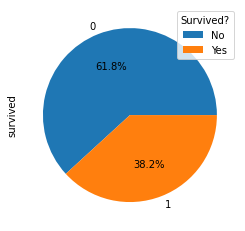

In [217]:
df.survived.value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.legend(["No", "Yes"]).set_title('Survived?')

#### b) Correlation matrix: 
- Most correlated variables with passenger survival:
    - Sex
    - pclass and fare

<AxesSubplot:>

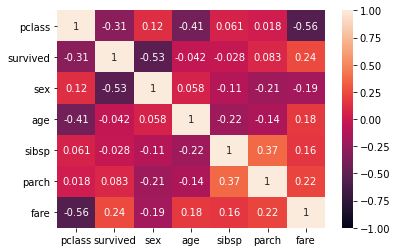

In [218]:
numerical_var=df.select_dtypes(include=np.number)
sns.heatmap(numerical_var.corr(),vmin=-1, vmax=1, annot=True)

#### c) Zoom in Age category

Create a categorical variable from the age. The categories are as follows: 
 - **0-2y** = baby
 - **2-5y** = toddler
 - **5-12y** = child
 - **12-18y** = teen
 - **18-30y** = young adult
 - **30-45y** = adult
 - **45-60y** = middle aged
 - **60-100y** = senior




In [219]:
bins = [0, 2, 5, 12, 18, 30, 45, 60, 100]
labels = ['baby', 'toddler', 'child', 'teen', 'young adult', 'adult', 'middle aged', 'senior']
df['age_interval'] = pd.cut(df['age'], bins, labels=labels)

In [220]:
df['age_interval'].value_counts()

young adult    558
adult          365
middle aged    137
teen           118
child           40
baby            34
senior          34
toddler         23
Name: age_interval, dtype: int64

Plot of the Age distribution of the survivors

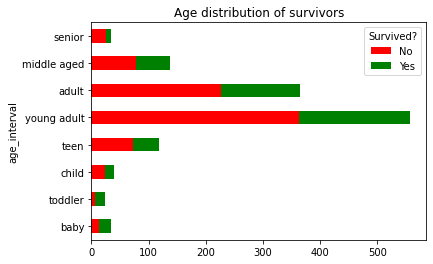

In [221]:
counts = df.groupby(['age_interval', 'survived'])['survived'].count().reset_index(name='count')
counts = counts.pivot(index='age_interval', columns='survived', values='count')
counts.plot.barh(stacked=True,title='Age distribution of survivors',color=['red', 'green'])
plt.legend(["No", "Yes"]).set_title('Survived?')

#### d) Zoom in Gender category


Plot of the Gender distribution of the survivors

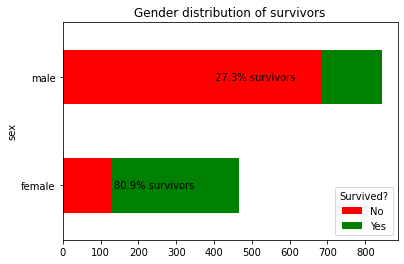

In [222]:
counts=df.groupby(['sex','survived'])['survived'].count().reset_index(name='count')
counts = counts.pivot(index='sex', columns='survived', values='count')
counts.rename({0:'female',1:'male'},inplace=True)
counts.plot.barh(stacked=True,title='Gender distribution of survivors',color=['red', 'green'])
df_total = counts[0] + counts[1]
df_rel = counts[counts.columns[1:]].div(df_total, 0)*100
for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(reversed(counts.iloc[:, 1:].cumsum(1)[n]), 
                                         reversed(counts[n]), reversed(df_rel[n]))):
        plt.text(cs+ab/2  , i, str(np.round(100-pc, 1)) + '% survivors', 
                 va = 'center', ha = 'center')
plt.legend(["No", "Yes"]).set_title('Survived?')



#### e) Zoom in pclass & fare category
Plot Survival probability per passenger class

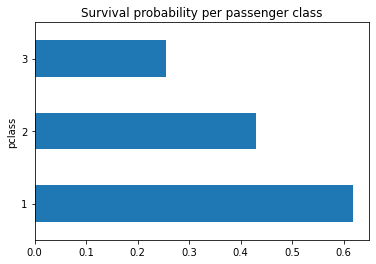

In [223]:
counts=df.groupby('pclass')['survived'].apply(lambda x : x.sum()/len(x)).plot(kind='barh',title="Survival probability per passenger class")


Boxplot of fare category : 
- Right Skewed 

<AxesSubplot:>

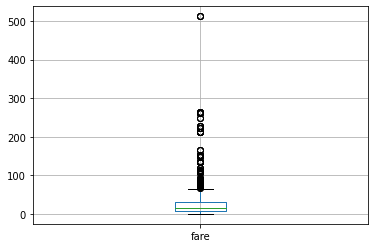

In [224]:
df.boxplot(column=['fare'])

Indeeed, most of the fare are between 0 and 100$

<AxesSubplot:ylabel='Density'>

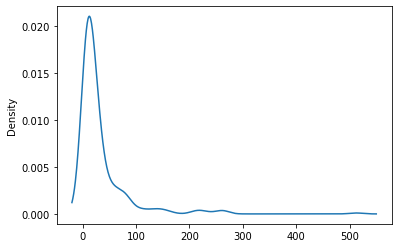

In [225]:
df['fare'].plot.density(ind=np.linspace(-20, 550, 700))


Solution : convert values with log.
- Better repartition

<AxesSubplot:ylabel='Density'>

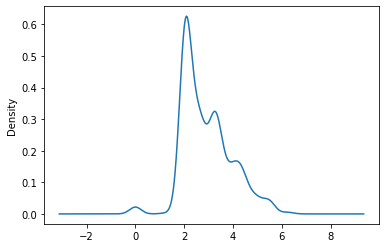

In [226]:
df['log_fare']=df['fare'].apply(lambda x: np.log(x) if x!=0 else 0)
df['log_fare'].plot.density()


new plot of the correlation matrix 

- increase of the correlation between fare (with log) and survied category. (0.24 -> 0.31)

<AxesSubplot:>

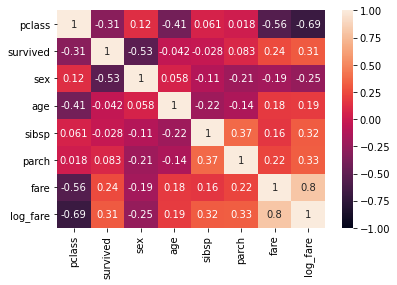

In [227]:
numerical_var=df.select_dtypes(include=np.number)
sns.heatmap(numerical_var.corr(),vmin=-1, vmax=1, annot=True)

### 4) Model Selection
#### a) Prepare the data

Get dummies from categorical variables. 
- We drop age_interval because we already have the age variable
- We use the drop_first parameter to get rid of useless variables and reduce colinearity

In [228]:
all_var=pd.get_dummies(df.drop('age_interval',axis=1),drop_first=True)

In [229]:
X,y=all_var.drop("survived",axis=1),all_var['survived']

We Standarize the data for fast calculation and best scores 

In [230]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
#nTest_scaled = scaler.transform(nTest)

Train Test Split

In [231]:
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.20, random_state=rand_state)

#### b) Try differents models
- We create a function that takes several ML model as inputs and gives a dataframe with :
 - The train Accuracy
 - The test Accuracy
 - The Cross Validation mean Accuracy
 - THe saved model

In [232]:

def get_metrics(models):
    results=pd.DataFrame()
    for m in tqdm(models):
        res={}
        res['Model']=str(m) 
        model=m.fit(X_train,y_train)
        y_pred=m.predict(X_test)
        res['Acc_Train']=m.score(X_train,y_train)
        res['Acc_Test']=accuracy_score(y_test,y_pred)
        res['Cross_val']=cross_val_score(m, X_scaled, y, cv=10).mean()
        res['saved_model']=m
        results=results.append(res,ignore_index=True)
    return results 

First Attempt : without hyperparameters

In [233]:
models= [
    RandomForestClassifier(random_state=rand_state),
    GaussianNB(),
    DecisionTreeClassifier(random_state=rand_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=rand_state),
    SVC(probability=True,random_state=rand_state),
    CatBoostClassifier(verbose=0,random_state=rand_state)]
results =get_metrics(models)
results

100%|██████████| 7/7 [00:18<00:00,  2.63s/it]


,Model,Acc_Train,Acc_Test,Cross_val,saved_model
0,RandomForestClassifier(random_state=25),0.983763,0.759542,0.742531,"(DecisionTreeClassifier(max_features='auto', r..."
1,GaussianNB(),0.768863,0.755725,0.711961,GaussianNB()
2,DecisionTreeClassifier(random_state=25),0.983763,0.751908,0.720370,DecisionTreeClassifier(random_state=25)
3,KNeighborsClassifier(),0.859599,0.751908,0.751644,KNeighborsClassifier()
4,LogisticRegression(random_state=25),0.803247,0.774809,0.762402,LogisticRegression(random_state=25)
5,"SVC(probability=True, random_state=25)",0.825215,0.790076,0.760857,"SVC(probability=True, random_state=25)"
6,<catboost.core.CatBoostClassifier object at 0x...,0.887297,0.790076,0.773829,<catboost.core.CatBoostClassifier object at 0x...


<AxesSubplot:ylabel='Model'>

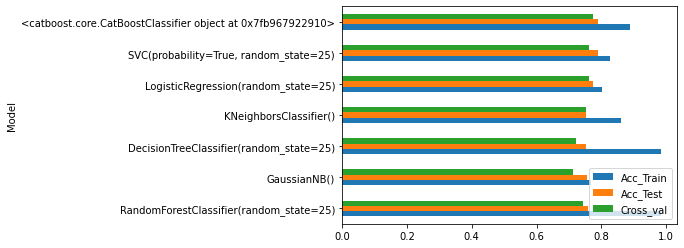

In [234]:
results.plot(x='Model',y=['Acc_Train','Acc_Test','Cross_val'],kind='barh')

Overfitting problem : Huge difference bewteen the accuracy of the training and testing phase for the following methods: 
- RandomForest
- DecisionTree
- KNeighboors
- Catboost

SVC has the best performance. Let's keep it as a referential and look closer to Tree bases models 

[Text(113.70639070371537, 211.7178947368421, 'X[1] <= -0.301\ngini = 0.471\nsamples = 1047\nvalue = [649, 398]'),
 Text(55.409083753148614, 200.2736842105263, 'X[0] <= 0.245\ngini = 0.4\nsamples = 376\nvalue = [104, 272]'),
 Text(20.450629722921914, 188.82947368421054, 'X[5] <= -0.138\ngini = 0.13\nsamples = 201\nvalue = [14, 187]'),
 Text(13.91486146095718, 177.38526315789474, 'X[2] <= 1.948\ngini = 0.285\nsamples = 64\nvalue = [11, 53]'),
 Text(12.228211586901764, 165.94105263157894, 'X[3] <= 0.001\ngini = 0.248\nsamples = 62\nvalue = [9, 53]'),
 Text(6.746599496221663, 154.49684210526317, 'X[4] <= 0.133\ngini = 0.176\nsamples = 41\nvalue = [4, 37]'),
 Text(5.059949622166247, 143.05263157894737, 'X[6] <= -0.357\ngini = 0.225\nsamples = 31\nvalue = [4, 27]'),
 Text(3.3732997481108313, 131.60842105263157, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(6.746599496221663, 131.60842105263157, 'X[2] <= -0.293\ngini = 0.308\nsamples = 21\nvalue = [4, 17]'),
 Text(3.3732997481108313, 12

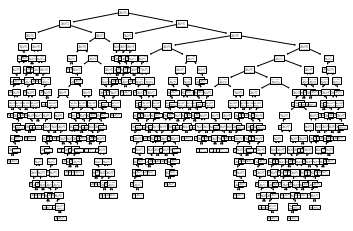

In [235]:
## Close look on the DecisionTree: 
tree_model=results.iloc[2]['saved_model']
tree.plot_tree(tree_model)

As we didn't specify any max_depth for trees, the models overfitted. let's try to do precise the max_depth parameter with DecisionTree and RandomForest to reduce overfitting and pruning 

2nd Attempt : With max_depth


In [236]:
models= [
    RandomForestClassifier(max_depth=3,random_state=rand_state),
    DecisionTreeClassifier(max_depth=3,random_state=rand_state),
        RandomForestClassifier(max_depth=5,random_state=rand_state),
    DecisionTreeClassifier(max_depth=5,random_state=rand_state),
    RandomForestClassifier(max_depth=10,random_state=rand_state),
    DecisionTreeClassifier(max_depth=10,random_state=rand_state),
    SVC(probability=True),
]
results2 =get_metrics(models)
results2

100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


,Model,Acc_Train,Acc_Test,Cross_val,saved_model
0,"RandomForestClassifier(max_depth=3, random_sta...",0.812798,0.801527,0.733318,"(DecisionTreeClassifier(max_depth=3, max_featu..."
1,"DecisionTreeClassifier(max_depth=3, random_sta...",0.815664,0.805344,0.743224,"DecisionTreeClassifier(max_depth=3, random_sta..."
2,"RandomForestClassifier(max_depth=5, random_sta...",0.845272,0.801527,0.753183,"(DecisionTreeClassifier(max_depth=5, max_featu..."
3,"DecisionTreeClassifier(max_depth=5, random_sta...",0.833811,0.782443,0.741715,"DecisionTreeClassifier(max_depth=5, random_sta..."
4,"RandomForestClassifier(max_depth=10, random_st...",0.936008,0.801527,0.767716,"(DecisionTreeClassifier(max_depth=10, max_feat..."
5,"DecisionTreeClassifier(max_depth=10, random_st...",0.911175,0.740458,0.733318,"DecisionTreeClassifier(max_depth=10, random_st..."
6,SVC(probability=True),0.825215,0.790076,0.760857,SVC(probability=True)


- Eventough we can notice a reduction in the difference between the training and testing accuracy with less deep trees, the models seems to be instable and still overfitting. 
- For this reason, we will choose the Support Vector Classifier, where relatively stable metrics are observed

#### c) Finetuning our final model : Support Vector Machine

In [237]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': ['scale','auto'],
              'kernel': ['rbf', 'sigmoid', 'linear']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 1/5] END .............C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV 2/5] END .............C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV 3/5] END .............C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV 4/5] END .............C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV 5/5] END .............C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV 1/5] END ..............C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV 2/5] END ..............C=0.1, gamma=scale, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             verbose=3)

In [238]:
print(f"The best paramters: {grid.best_params_} with a score of {grid.best_score_}")


The best paramters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} with a score of 0.8128730918204603


#### d) Close look at our final model, metrics and confusion matrix

Confusion matrix

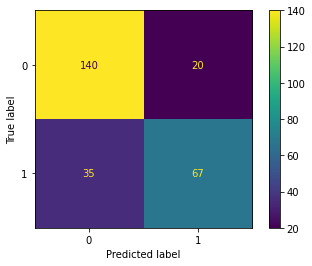

In [239]:
#choosen model= SVC
final_model=SVC(C=1,gamma='scale',kernel='rbf')
final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)

disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred),display_labels=final_model.classes_)
disp.plot()

In [240]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       160
           1       0.77      0.66      0.71       102

    accuracy                           0.79       262
   macro avg       0.79      0.77      0.77       262
weighted avg       0.79      0.79      0.79       262



## Final score 81 % 

#### What could be done to have better performance ? 
- Try to do more feature engenieering, to come up with more correlated data
- test other ML algorithms (XGBoost, MLP)
- Fine tune all the tested algorithms
- Try to use SMOTE to have a 50/50 repartition of the values (regarding the dependent variable)